In [1]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import json
import matplotlib.animation as animation
import scipy.misc
import cv2

In [2]:
!ls logs1/pbtdqnsharedCommEnLv30/ep\:4200.json
!ls logs1/pbtacshared2dcommEnAlphav12/model
with open('logs1/pbtdqnsharedCommEnLv30/ep:4200.json') as f:
                data = json.load(f)

logs1/pbtdqnsharedCommEnLv30/ep:4200.json
logs1/pbtacshared2dcommEnAlphav12/model


In [6]:
len(data['co'][0][0]), [i[0] for i in data['co']]

(4,
 [[-0.5265758037567139,
   -0.16585993766784668,
   -0.1650247871875763,
   0.4608633518218994],
  [-0.5120161771774292,
   -0.19193756580352783,
   -0.21048808097839355,
   0.46823060512542725],
  [-0.4948858916759491,
   -0.1978057622909546,
   -0.3059841990470886,
   0.5157695412635803],
  [-0.483498752117157,
   -0.16271311044692993,
   -0.33220627903938293,
   0.5787584185600281],
  [-0.4153672158718109,
   -0.1664147973060608,
   -0.35947537422180176,
   0.5908194780349731],
  [-0.4121023714542389,
   -0.16552069783210754,
   -0.4383726716041565,
   0.590707004070282],
  [-0.42902234196662903,
   -0.14912182092666626,
   -0.4586241841316223,
   0.6012925505638123],
  [-0.3562520146369934,
   -0.12835031747817993,
   -0.4375183582305908,
   0.5069580674171448],
  [-0.31999513506889343,
   -0.1492319107055664,
   -0.48695433139801025,
   0.5401800274848938],
  [-0.3202349543571472,
   -0.14009401202201843,
   -0.5043219327926636,
   0.5413833260536194],
  [-0.24990719556808472,

In [5]:
from models.models import DQN2D, DQN
from mas import *
import torch
from torch.distributions import Categorical
env = GameEnv(0.6)
env.reset()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
att=0
policy_net = DQN2D(84,84, {'en':100,'att':att,'comma':'t'}).to(device)
PATH = 'logs1/pbtacshared2dcommEnAlphav10/model'
PATH = 'logs1/pbtdqnsharedCommEnLv30/model'
PATH = 'logs1/pbtdqnsharedCommEnTanhv30/model'
PATH = 'logs1/pbtdqnshared2dAttv30/model'
PATH = 'logs1/pbtdqnsharedCommTan1Bonusv20/model'
#PATH = 'logs1/pbtdqnshared2dCommTan1v40/model'
policy_net.load_state_dict(torch.load(PATH, map_location= 'cuda' if torch.cuda.is_available() else 'cpu')) 
def getStates( env):
        screen1 = env.train_render(0).transpose((2, 0, 1))
        screen1 = np.ascontiguousarray(screen1, dtype=np.float32) / 255
        screen2 = env.train_render(1).transpose((2, 0, 1))
        screen2 = np.ascontiguousarray(screen2, dtype=np.float32) / 255
        return torch.from_numpy(screen1).unsqueeze(0).to(device),\
    torch.from_numpy(screen2).unsqueeze(0).to(device) 
def select_action( state, comm, policy_net):
        return policy_net(state, 1, comm)[0].max(1)[1].view(1, 1),1,1
        probs1, _ = policy_net(state, 1, comm)#.cpu().data.numpy()
        m = Categorical(logits=probs1)
        action = m.sample()
        return action.view(1, 1), m.log_prob(action), m.entropy()
def getaction( state1, state2, test=False):
        mes = torch.tensor([np.random.rand(4)], device=device)
        #maybe error
        idC = 1
        if att==1:
            _,comm2,att2 = policy_net(state2, 0, mes)#[idC] if not test else mes
            #if (test and  0<self.prob) or np.random.rand()<self.prob else mes
            _,comm1,att1 = policy_net(state1, 0, mes)#[idC]  if not test else mes
            #if (test and  0<self.prob) or np.random.rand()<self.prob else mes
        else:
            _,comm2 = policy_net(state2, 0, mes)#[idC] if not test else mes
            #if (test and  0<self.prob) or np.random.rand()<self.prob else mes
            _,comm1 = policy_net(state1, 0, mes)#[idC]  if not test else mes
        action1, logp1, ent1 = select_action(state1,  comm2, policy_net)
        action2, logp2, ent2 = select_action(state2,  comm1, policy_net)
        rem =[logp1, ent1, logp2, ent2]
        if att!=1:
             att1, att2 = action1, action2
        return action1, action2, [comm1, comm2, att1, att2]

In [42]:
rt = 0
env.reset()
for t in range(100):#sep function
                    state1,state2 = getStates(env)
                    action1, action2, r = getaction(state1,state2, test=True)
                    comm1,comm2 = r
                    reward1, reward2 = env.move(action1.item(), action2.item())
                    rt+= reward1+ reward2
                    #print(comm1.cpu().data.numpy(),comm2.cpu().data.numpy(), 
                    print(t, 'Km',kmn.predict(comm1.cpu().data.numpy()), kmn.predict(comm2.cpu().data.numpy()) ,
                          ',ac:',action1.item(), action2.item(), ',ag1:', env.agent1.x, env.agent1.y,
                          ',ag2:', env.agent2.x, env.agent2.y, ',re:', reward1, reward2,
                          'dx', env.agent2.x-env.agent1.x,'dy', env.agent2.y-env.agent1.y)
rt

0 Km [4] [4] ,ac: 0 0 ,ag1: 1 5 ,ag2: 29 5 ,re: 0 0 dx 28 dy 0
1 Km [4] [4] ,ac: 0 0 ,ag1: 2 5 ,ag2: 28 5 ,re: 0 0 dx 26 dy 0
2 Km [4] [4] ,ac: 0 0 ,ag1: 3 5 ,ag2: 27 5 ,re: 0 0 dx 24 dy 0
3 Km [4] [4] ,ac: 0 0 ,ag1: 4 5 ,ag2: 26 5 ,re: 0 0 dx 22 dy 0
4 Km [4] [4] ,ac: 0 0 ,ag1: 5 5 ,ag2: 25 5 ,re: 0 0 dx 20 dy 0
5 Km [0] [0] ,ac: 0 0 ,ag1: 6 5 ,ag2: 24 5 ,re: 0 0 dx 18 dy 0
6 Km [0] [0] ,ac: 0 0 ,ag1: 7 5 ,ag2: 23 5 ,re: 0 0 dx 16 dy 0
7 Km [0] [0] ,ac: 0 0 ,ag1: 8 5 ,ag2: 22 5 ,re: 0 0 dx 14 dy 0
8 Km [0] [0] ,ac: 0 0 ,ag1: 9 5 ,ag2: 21 5 ,re: 0 0 dx 12 dy 0
9 Km [3] [3] ,ac: 0 0 ,ag1: 10 5 ,ag2: 20 5 ,re: 0 0 dx 10 dy 0
10 Km [1] [1] ,ac: 0 0 ,ag1: 11 5 ,ag2: 19 5 ,re: 0 0 dx 8 dy 0
11 Km [1] [1] ,ac: 0 0 ,ag1: 12 5 ,ag2: 18 5 ,re: 0 0 dx 6 dy 0
12 Km [1] [1] ,ac: 0 0 ,ag1: 13 5 ,ag2: 17 5 ,re: 1 1 dx 4 dy 0
13 Km [2] [2] ,ac: 0 0 ,ag1: 14 5 ,ag2: 16 5 ,re: 1 1 dx 2 dy 0
14 Km [2] [2] ,ac: 3 3 ,ag1: 14 6 ,ag2: 16 4 ,re: 1 1 dx 2 dy -2
15 Km [2] [2] ,ac: 0 0 ,ag1: 15 6 ,ag2: 15 4 ,re

119

In [6]:
rt = 0
env.reset()
db = []
def pro(a):
    return a#np.round(a,2)#np.where(a>0.005,1,0)
co = []
policy_net.eval()
for t in range(100):#sep function
                    state1,state2 = getStates(env)
                    action1, action2, r = getaction(state1,state2, test=False)
                    comm1,comm2,att1,att2 = r
                    co.append([comm2.cpu().data.numpy()[0], att2.item(), env.getState(),
                               env.agent2.x-env.agent1.x, env.agent2.y-env.agent1.y,
                              action1.item(), action2.item()])
                    it = [env.getState(),[action1.item(), action2.item()]]
                    reward1, reward2 = env.move(action1.item(), action2.item())
                    rt+= reward1+ reward2
                    it.extend([[reward1,reward2],env.getState()])
                    db.append(it)
                    #print(comm1.cpu().data.numpy(),comm2.cpu().data.numpy(), 
                    print(t, 'Km',pro(comm1.cpu().data.numpy()), pro(comm2.cpu().data.numpy()) ,
                          'att', att1.item(),att2.item(),
                          ',ac:',action1.item(), action2.item(), ',ag1:', env.agent1.x, env.agent1.y,
                          ',ag2:', env.agent2.x, env.agent2.y, ',re:', reward1, reward2,
                          'dx', env.agent2.x-env.agent1.x,'dy', env.agent2.y-env.agent1.y)
rt

/share/apps2/anaconda/anaconda3/latest/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0 Km [[-1.1648111 -1.3611376 -1.5357627 -1.5814399]] [[-1.1648111 -1.3611376 -1.5357627 -1.5814399]] att 0 0 ,ac: 0 0 ,ag1: 1 5 ,ag2: 29 5 ,re: 0 0 dx 28 dy 0
1 Km [[-1.0753368 -1.372683  -1.5753632 -1.5641379]] [[-1.0753368 -1.372683  -1.5753632 -1.5641379]] att 0 0 ,ac: 0 0 ,ag1: 2 5 ,ag2: 28 5 ,re: 0 0 dx 26 dy 0
2 Km [[-1.0277852 -1.3828427 -1.5126638 -1.5136738]] [[-1.0277852 -1.3828427 -1.5126638 -1.5136738]] att 0 0 ,ac: 0 0 ,ag1: 3 5 ,ag2: 27 5 ,re: 0 0 dx 24 dy 0
3 Km [[ 1.0781008 -1.4174285 -1.5235701 -1.5239207]] [[ 1.0781008 -1.4174285 -1.5235701 -1.5239207]] att 0 0 ,ac: 0 0 ,ag1: 4 5 ,ag2: 26 5 ,re: 0 0 dx 22 dy 0
4 Km [[ 1.0353031 -1.409318  -1.4361761 -1.5276803]] [[ 1.0353031 -1.409318  -1.4361761 -1.5276803]] att 0 0 ,ac: 0 0 ,ag1: 5 5 ,ag2: 25 5 ,re: 0 0 dx 20 dy 0
5 Km [[ 1.0135027 -1.3801174 -1.5133057 -1.5465893]] [[ 1.0135027 -1.3801174 -1.5133057 -1.5465893]] att 0 0 ,ac: 0 0 ,ag1: 6 5 ,ag2: 24 5 ,re: 0 0 dx 18 dy 0
6 Km [[ 1.1010548 -1.3789521 -1.5110474 -1.556

54 Km [[ 1.2674501 -1.4131663 -1.2677202 -1.5777689]] [[ 1.2353817 -1.3975471 -1.2960416 -1.5281194]] att 1 3 ,ac: 1 3 ,ag1: 15 4 ,ag2: 16 5 ,re: 1 1 dx 1 dy 1
55 Km [[ 1.0610781 -1.3953975 -1.3405385 -1.5648687]] [[ 1.1677737 -1.4083111 -1.3277504 -1.5329217]] att 3 0 ,ac: 3 0 ,ag1: 15 4 ,ag2: 16 5 ,re: 0 0 dx 1 dy 1
56 Km [[ 1.0891541 -1.4273235 -1.3688179 -1.5699971]] [[ 1.2115027 -1.4666736 -1.3255494 -1.5600958]] att 3 1 ,ac: 3 1 ,ag1: 15 5 ,ag2: 17 5 ,re: 1 1 dx 2 dy 0
57 Km [[ 1.1885781 -1.3308451 -1.4542282 -1.4880049]] [[ 1.2273068 -1.3435968 -1.4628882 -1.4608006]] att 3 0 ,ac: 3 0 ,ag1: 15 6 ,ag2: 16 5 ,re: 1 0 dx 1 dy -1
58 Km [[ 1.301141  -1.1875628 -1.3266213 -1.4274027]] [[ 1.2141601 -1.3328043 -1.3051721 -1.513001 ]] att 1 3 ,ac: 1 3 ,ag1: 14 6 ,ag2: 16 4 ,re: 1 1 dx 2 dy -2
59 Km [[ 1.18092   -1.3363401 -1.4621384 -1.4645512]] [[ 1.1758235 -1.3354384 -1.452013  -1.4497259]] att 0 0 ,ac: 0 0 ,ag1: 15 6 ,ag2: 15 4 ,re: 0 0 dx 0 dy -2
60 Km [[ 1.2950342 -1.2386357 -1.3565

116

In [93]:
co1 = [i[0] for i in co]
np.amin(co1,0),np.amax(co1,0)

(array([-1.9999957, -1.5480931,  1.978164 , -1.7880349], dtype=float32),
 array([-1.9997809,  1.3606297,  1.9996692,  1.2236681], dtype=float32))

(array([ 5., 24., 27., 18., 15.,  4.,  5.,  1.,  0.,  1.]),
 array([2.57444808e-05, 4.39611951e-05, 6.21779094e-05, 8.03946237e-05,
        9.86113380e-05, 1.16828052e-04, 1.35044767e-04, 1.53261481e-04,
        1.71478195e-04, 1.89694910e-04, 2.07911624e-04]),
 <a list of 10 Patch objects>)

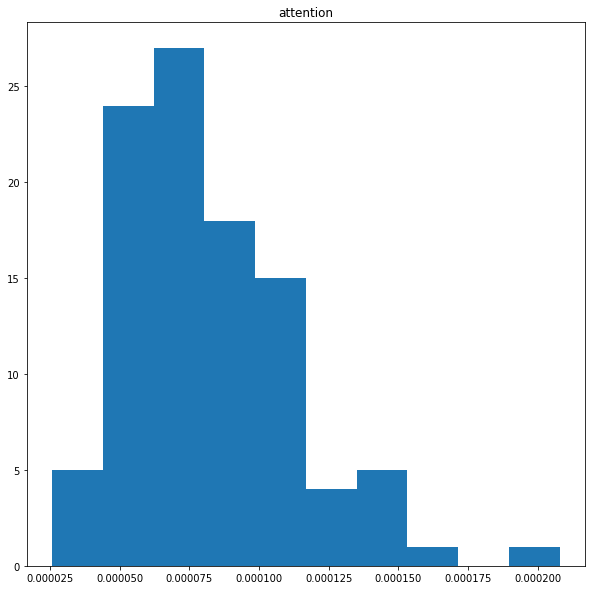

In [48]:
plt.figure(figsize=(10,10))
plt.title('attention')
plt.hist(np.array(co1))

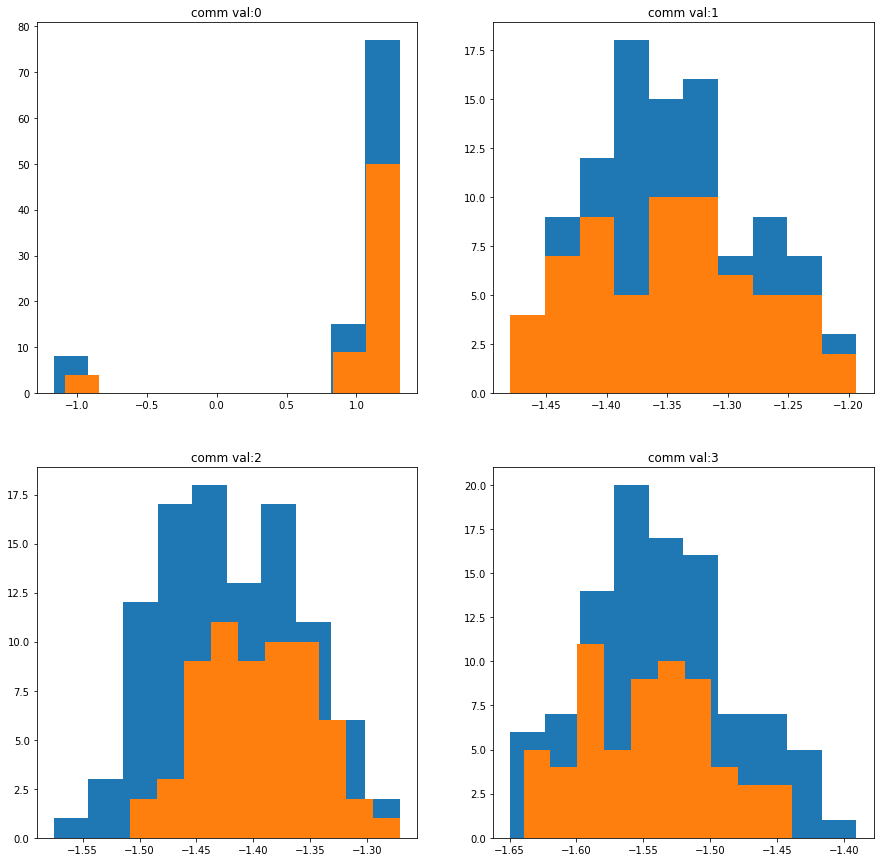

In [7]:
plt.figure(figsize=(15,15))
for i in range(4):
    co11 = [il[0][i] for il in co]
    plt.subplot(2,2,i+1)
    plt.title('comm val:'+str(i))
    co12 = [il[0][i] for il in co if il[1]>0.0001]
    plt.hist(np.array(co11))
    plt.hist(np.array(co12))

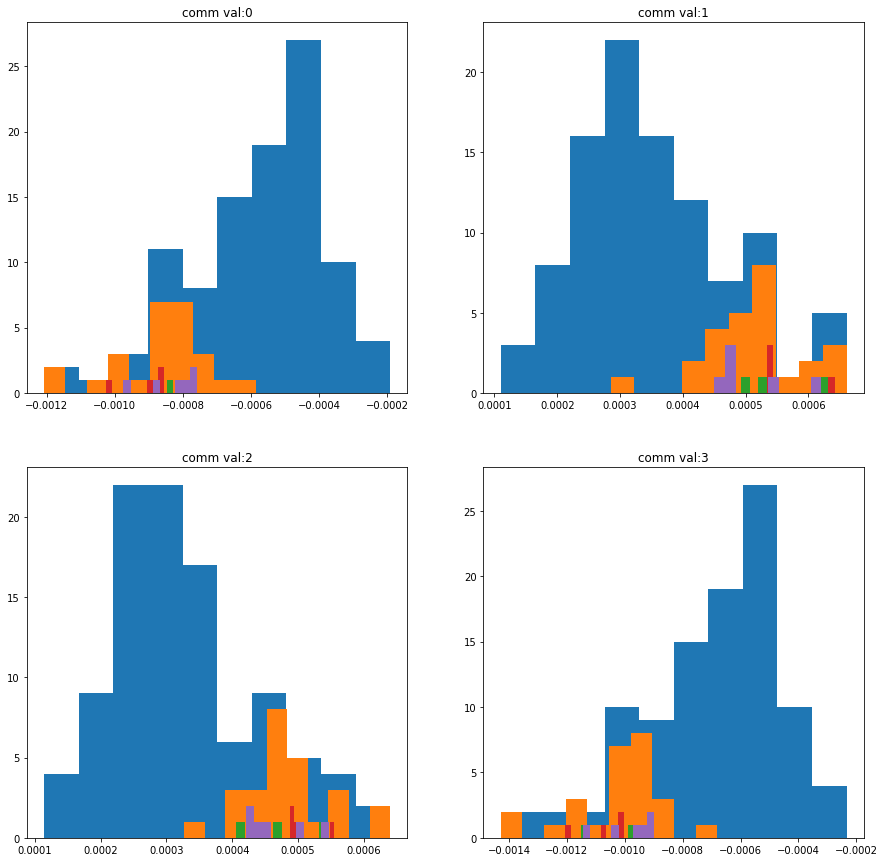

In [80]:
plt.figure(figsize=(15,15))
for i in range(4):
    co11 = [il[0][i] for il in co]
    plt.subplot(2,2,i+1)
    plt.title('comm val:'+str(i))
    co12 = [il[0][i] for il in co if il[1]>0.0001]
    plt.hist(np.array(co11))
    plt.hist(np.array(co12))
    co121 = [il[0][i] for il in co if il[1]>0.0001 and il[-1]==1]
    plt.hist(np.array(co121))
    co121 = [il[0][i] for il in co if il[1]>0.0001 and il[-1]==2]
    plt.hist(np.array(co121))
    co121 = [il[0][i] for il in co if il[1]>0.0001 and il[-1]==3]
    plt.hist(np.array(co121))

In [51]:
0.0001
co1 = [i[-4:]+i[1:2] for i in co if i[1]>0.0001]
co1

[[28, 0, 0, 0, 0.0002079116238746792],
 [26, 0, 0, 0, 0.00010056937753688544],
 [24, 0, 0, 0, 0.00013972463784739375],
 [20, 0, 0, 0, 0.00013695587404072285],
 [16, 0, 0, 0, 0.00013851787662133574],
 [14, 0, 0, 0, 0.00011237942817388102],
 [12, 0, 0, 0, 0.00017012089665513486],
 [10, 0, 0, 0, 0.00014288020611274987],
 [8, 0, 0, 0, 0.00010867014498217031],
 [-2, 0, 2, 1, 0.00011328102846164256],
 [-3, 1, 3, 2, 0.00011487343726912513],
 [-3, 1, 1, 1, 0.00013476770254783332],
 [-1, 1, 2, 2, 0.00013569665316026658],
 [-1, 3, 3, 3, 0.00010744204337242991],
 [-1, -1, 0, 3, 0.00011728325625881553],
 [0, -2, 2, 3, 0.00012950999371241778],
 [3, 1, 0, 0, 0.00011609036300797015],
 [-1, 1, 2, 3, 0.00010613738413667306],
 [-3, 1, 3, 0, 0.0001065549804479815],
 [0, 4, 3, 3, 0.00010603005648590624],
 [-2, 2, 0, 0, 0.00011570443894015625],
 [-4, 0, 1, 1, 0.00010538061906117946],
 [-1, -3, 2, 2, 0.0001223861036123708],
 [-2, 0, 2, 0, 0.00011554722004802898],
 [-3, 1, 2, 3, 0.00011125453602289781],
 [-2

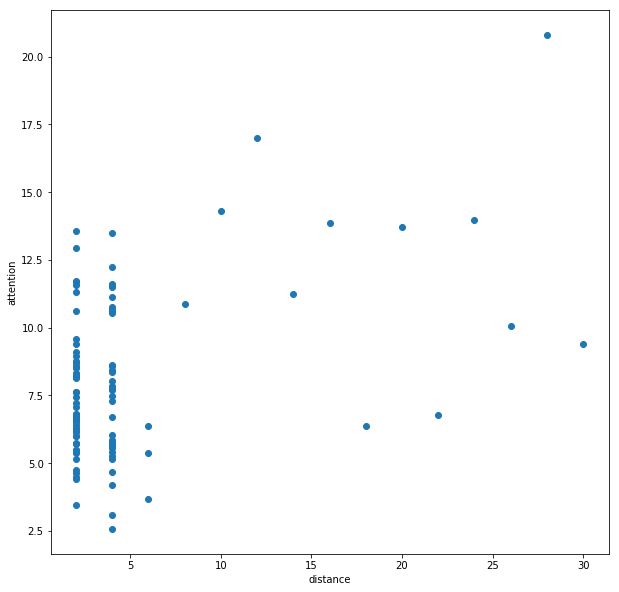

In [63]:
x1 = [abs(i[-4])+abs(i[-3]) for i in co]
y1 = np.array([i[1] for i in co])*100000
plt.figure(figsize=(10,10))
plt.xlabel('distance')
plt.ylabel('attention')
plt.scatter(x1,y1)

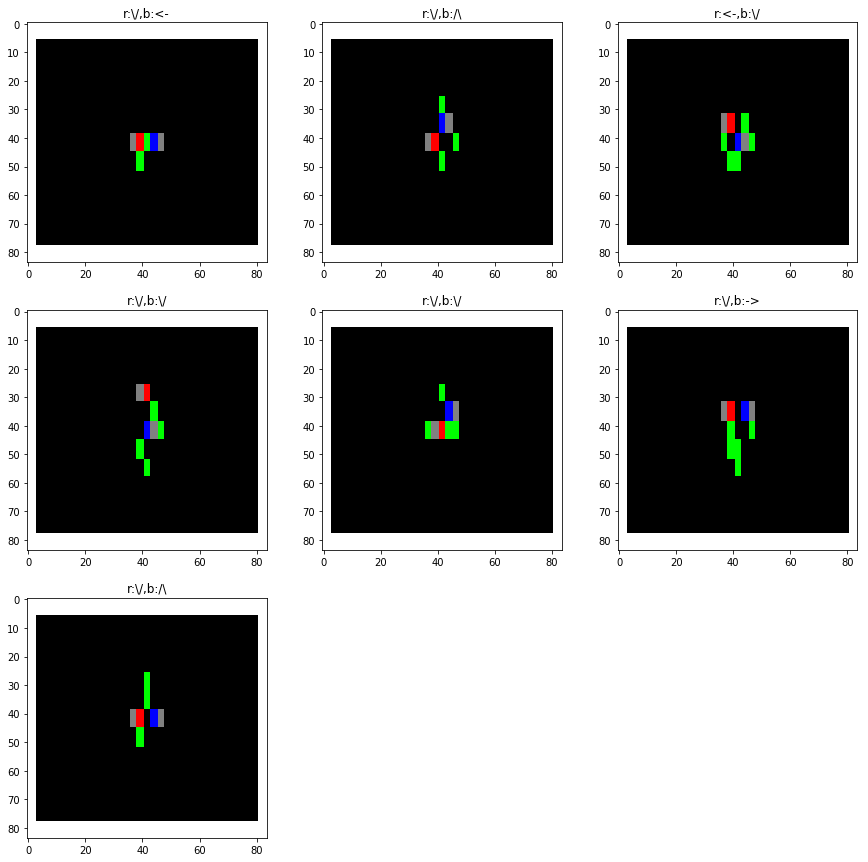

In [75]:
co1 = [i for i in co if i[1]>0.0001 and abs(i[-4])+abs(i[-3])<4]
plt.figure(figsize=(15,15))
ac1 = {1: '->', 0: '<-', 3: '/\\', 2: '\\/',4:'',5:'',6:'',7:''}
ac2 = {1: '<-', 0: '->', 3: '\\/', 2: '/\\',4:'',5:'',6:'',7:''}
for i,c in  enumerate(co1[:9]):
    env.getFrom(c[2])
    plt.subplot(3,3,i+1)
    plt.title('r:'+ac1[c[-2]]+',b:'+ac2[c[-1]])
    plt.imshow(env.train_render(1))

In [114]:
co1 = [i for i in co if i[1]>0.0001 and abs(i[-4])+abs(i[-3])<3]
for i,c in enumerate(co1[:6]):
    env.getFrom(c[2])
    state1,state2 =  getStates(env)
    comm = torch.tensor([c[0]],device=device)
    ac = policy_net(state2, 1, comm)[0].max(1)[1].item()
    print('action now:',ac, ',action then:', c[-1], ',random mess from db:')
    for j in range(len(co1[:6])):
        id = np.random.randint(len(co))
        comm = torch.tensor([co[id][0]],device=device)
        ac = policy_net(state2, 1, comm)[0].max(1)[1].item()
        print(ac,co[id][0])

action now: 1 ,action then: 1 ,random mess from db:
1 [-0.00063579  0.00036893  0.00036262 -0.00073539]
1 [-0.00048446  0.00028395  0.00025917 -0.00055883]
1 [-0.0003677   0.00021231  0.00019193 -0.00044101]
1 [-0.00072852  0.00043058  0.00039186 -0.00083769]
action now: 0 ,action then: 0 ,random mess from db:
0 [-0.00059114  0.00035945  0.00032015 -0.00067509]
0 [-0.00101025  0.00048551  0.0005504  -0.00114849]
0 [-0.00180257  0.00106274  0.00103455 -0.00217146]
0 [-0.00047281  0.00031728  0.0002457  -0.00054736]
action now: 0 ,action then: 0 ,random mess from db:
0 [-0.00088152  0.00043156  0.00045255 -0.0009648 ]
0 [-0.00055491  0.00034524  0.00031203 -0.00064388]
0 [-0.00053997  0.00034747  0.0002752  -0.00064053]
0 [-0.00101025  0.00048551  0.0005504  -0.00114849]
action now: 0 ,action then: 0 ,random mess from db:
0 [-0.00058149  0.00035626  0.00034585 -0.00070738]
0 [-0.00020358  0.00011997  0.00011991 -0.00023964]
0 [-0.00082728  0.00046683  0.00042747 -0.00094669]
0 [-0.000271

In [9]:
co1 = [i for i in co]
for i,c in enumerate(co1):
    id1 = np.random.randint(len(co))
    c = co[id1]
    env.getFrom(c[2])
    state1,state2 =  getStates(env)
    comm = torch.tensor([c[0]],device=device)
    ac1 = policy_net(state2, 1, comm)[0].max(1)[1].item()
    #print('action now:',ac, ',action then:', c[-1], ',random mess from db:')
    if i%10==0:
        print(i)
    for j in range(len(co1[:16])):
        id = np.random.randint(len(co))
        comm = torch.tensor([co[id][0]],device=device)
        ac = policy_net(state2, 1, comm)[0].max(1)[1].item()
        if ac1!=ac:
            print(i,ac, ac1,co[id][0],id, id1)

0
10
11 3 1 [ 1.0220401 -1.4198041 -1.5088723 -1.5463111] 46 28
11 3 1 [ 1.2124264 -1.2451264 -1.4368215 -1.5597746] 35 28
11 3 1 [ 1.0969268 -1.3669629 -1.5066636 -1.5067713] 37 28
11 3 1 [ 1.0908271 -1.384614  -1.3844266 -1.5210519] 23 28
20
30
40
41 1 3 [ 1.2185268 -1.3113817 -1.3409274 -1.4178178] 13 66
41 1 3 [ 1.2230923 -1.3045801 -1.318997  -1.5093803] 41 66
41 1 3 [ 1.1360749 -1.4538628 -1.4403856 -1.5689139] 21 66
41 1 3 [ 1.2230923 -1.3045801 -1.318997  -1.5093803] 41 66
41 1 3 [ 1.1700574 -1.3581972 -1.3708832 -1.4810702] 33 66
41 1 3 [ 1.2011344 -1.3907186 -1.4822719 -1.4333379] 85 66
41 1 3 [ 1.310218  -1.4440064 -1.3635625 -1.5060155] 74 66
41 1 3 [ 1.2011344 -1.3907186 -1.4822719 -1.4333379] 85 66
50
51 3 1 [ 1.0570449 -1.3428342 -1.5200555 -1.4802237] 7 98
51 3 1 [ 1.0861006 -1.3277228 -1.4583671 -1.5041891] 18 98
51 3 1 [ 1.0242981 -1.2894249 -1.4414548 -1.5591346] 95 98
59 3 1 [ 1.0811949 -1.4020956 -1.4085879 -1.639447 ] 38 98
59 3 1 [ 1.0969268 -1.3669629 -1.5066636

[ 1.2181883 -1.4333733 -1.3212063 -1.5903335]
[ 1.1944122 -1.4189937 -1.3884774 -1.6260011]
[ 1.0733821 -1.4303493 -1.344831  -1.5347838]


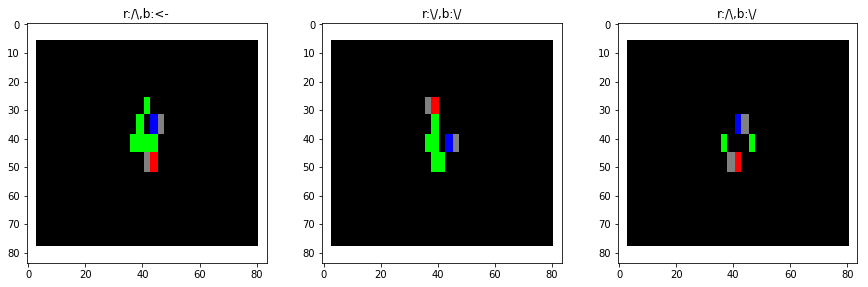

In [10]:
plt.figure(figsize=(15,15))
ac1 = {1: '->', 0: '<-', 3: '/\\', 2: '\\/',4:'',5:'',6:'',7:''}
ac2 = {1: '<-', 0: '->', 3: '\\/', 2: '/\\',4:'',5:'',6:'',7:''}
for i,c in  enumerate([28, 98, 66]):
    c = co[c]
    print(c[0])
    env.getFrom(c[2])
    plt.subplot(3,3,i+1)
    plt.title('r:'+ac1[c[-2]]+',b:'+ac2[c[-1]])
    plt.imshow(env.train_render(1))

[-1.9999396  1.1577996  1.9938169 -1.5157938]


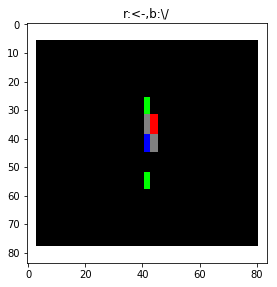

In [111]:
#25->63,60,66,97
'''
1-> 3 [-1.9999894 -1.4269083  1.9992268 -1.0794022] 42 25
1 3 [-1.9999788 -1.0964993  1.9978869 -1.2357938] 99 25
1 3 [-1.9999661 -1.0405748  1.9967885 -1.4169592] 85 25
1 3 [-1.9999875 -1.3373265  1.9989772 -1.1032962] 82 25
1 3 [-1.9999824 -1.2281764  1.9984179 -1.1977807] 38 25
'''
plt.figure(figsize=(15,15))
ac1 = {1: '->', 0: '<-', 3: '/\\', 2: '\\/',4:'',5:'',6:'',7:''}
ac2 = {1: '<-', 0: '->', 3: '\\/', 2: '/\\',4:'',5:'',6:'',7:''}
for i,c in  enumerate([25]):
    c = co[c]
    print(c[0])
    env.getFrom(c[2])
    plt.subplot(3,3,i+1)
    plt.title('r:'+ac1[c[-2]]+',b:'+ac2[c[-1]])
    plt.imshow(env.train_render(1))

In [100]:
co1 = [i for i in co if i[1]>0.0001 and abs(i[-4])+abs(i[-3])<3]
for i,c in enumerate(co1[6:16]):
    env.getFrom(c[2])
    state1,state2 =  getStates(env)
    comm = torch.tensor([c[0]],device=device)
    ac = policy_net(state2, 1, comm)[0].max(1)[1].item()
    print('action now:',ac, ',action then:', c[-1], ',random mess from db:')
    for j in range(6):
        id = np.random.randint(len(co))
        comm = torch.tensor([co[id][0]],device=device)
        ac = policy_net(state2, 1, comm)[0].max(1)[1].item()
        print(ac,co[id][0])

action now: 2 ,action then: 2 ,random mess from db:
2 [-1.9999793 -1.1923574  1.9982048 -1.2671167]
2 [-1.9999928 -1.3788958  1.9993291  1.0278732]
2 [-1.9998744  1.1611116  1.9900196 -1.7491235]
2 [-1.9998939  1.19962    1.9907099 -1.7082305]
2 [-1.9999639  1.0761337  1.9961433 -1.4057152]
2 [-1.9997809  1.3552666  1.978164  -1.7880349]
action now: 1 ,action then: 1 ,random mess from db:
1 [-1.9999957 -1.5480931  1.9996692  1.0847744]
1 [-1.9999886 -1.3739488  1.9990877 -1.1620878]
1 [-1.9999793 -1.0710591  1.9975373 -1.2559066]
1 [-1.9999492  1.1163596  1.9947717 -1.5248344]
1 [-1.9999957 -1.5480931  1.9996692  1.0847744]
1 [-1.9999915 -1.3810532  1.9992315  1.0218307]
action now: 3 ,action then: 3 ,random mess from db:
3 [-1.9999202  1.1313692  1.9923061 -1.5992441]
3 [-1.999898   1.2008001  1.9901781 -1.6683733]
3 [-1.9999924 -1.4700475  1.9994059  1.025885 ]
3 [-1.9999738 -1.1243085  1.9976643 -1.4662482]
3 [-1.9999206  1.2464678  1.9911871 -1.61267  ]
3 [-1.9999933 -1.4792961  1.

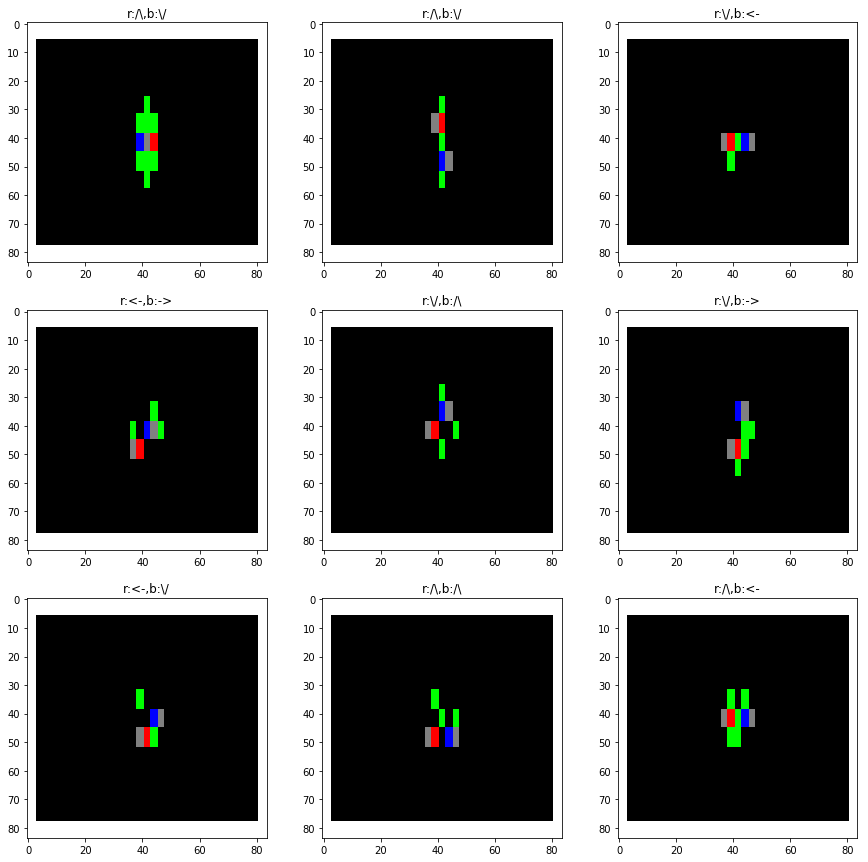

In [74]:
co1 = [i for i in co if i[1]<0.001 and abs(i[-4])+abs(i[-3])<4]
plt.figure(figsize=(15,15))
ac1 = {1: '->', 0: '<-', 3: '/\\', 2: '\\/',4:'',5:'',6:'',7:''}
ac2 = {1: '<-', 0: '->', 3: '\\/', 2: '/\\',4:'',5:'',6:'',7:''}
for i,c in  enumerate(co1[:9]):
    env.getFrom(c[2])
    plt.subplot(3,3,i+1)
    plt.title('r:'+ac1[c[-2]]+',b:'+ac2[c[-1]])
    plt.imshow(env.train_render(1))

In [13]:
import os
with open(os.path.join('logs1/dbCommEL','pbtdqnsharedCommEnLv30Demonstration.json'), 'w') as outfile:
        json.dump(db, outfile)
#logs1/dbCommEL/pbtdqnsharedCommEnLv30Demonstration.json

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
with open('logs1/dbCommEL/pbtdqnsharedCommEnLv30.json') as f:
                data = json.load(f)


In [4]:
X = np.array([i[0] for i in data]+[i[1] for i in data])
Y = np.array([i[2] for i in data]+[i[3] for i in data])
train_X, test_X, train_y, test_y = train_test_split(X,
                                                    Y, test_size=0.3)

In [5]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((11200, 4), (4800, 4), (11200,), (4800,))

In [24]:
# wrap up with Variable in pytorch
train_X = Variable(torch.Tensor(train_X).float())
test_X = Variable(torch.Tensor(test_X).float())
train_y = Variable(torch.Tensor(train_y).long())
test_y = Variable(torch.Tensor(test_y).long())

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        X = self.fc3(X)
        X = self.softmax(X)

        return X


In [26]:
net = Net()

criterion = nn.CrossEntropyLoss()# cross entropy loss

optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

for epoch in range(10000):
    optimizer.zero_grad()
    out = net(train_X)
    loss = criterion(out, train_y)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print ('number of epoch', epoch, 'loss', loss.item())

predict_out = net(test_X)
_, predict_y = torch.max(predict_out, 1)

print ('prediction accuracy', accuracy_score(test_y.data, predict_y.data))

print ('macro precision', precision_score(test_y.data, predict_y.data, average='macro'))
print ('micro precision', precision_score(test_y.data, predict_y.data, average='micro'))
print ('macro recall', recall_score(test_y.data, predict_y.data, average='macro'))
print ('micro recall', recall_score(test_y.data, predict_y.data, average='micro'))

number of epoch 0 loss 1.386035442352295
number of epoch 100 loss 1.381399154663086
number of epoch 200 loss 1.377166509628296
number of epoch 300 loss 1.3735826015472412
number of epoch 400 loss 1.3707932233810425
number of epoch 500 loss 1.3687868118286133
number of epoch 600 loss 1.367429256439209
number of epoch 700 loss 1.366550087928772
number of epoch 800 loss 1.3659849166870117
number of epoch 900 loss 1.3656132221221924
number of epoch 1000 loss 1.3653584718704224
number of epoch 1100 loss 1.3651673793792725
number of epoch 1200 loss 1.365017056465149
number of epoch 1300 loss 1.3648878335952759
number of epoch 1400 loss 1.3647633790969849
number of epoch 1500 loss 1.3646557331085205
number of epoch 1600 loss 1.3645424842834473
number of epoch 1700 loss 1.364437460899353
number of epoch 1800 loss 1.3643351793289185
number of epoch 1900 loss 1.3642290830612183
number of epoch 2000 loss 1.3641294240951538
number of epoch 2100 loss 1.3640248775482178
number of epoch 2200 loss 1.3

In [ ]:
'''
x-comm, y-action
prediction accuracy 0.5808333333333333
macro precision 0.4510017876271749
micro precision 0.5808333333333333
macro recall 0.5754705184136772
micro recall 0.5808333333333333

x-comm, y-distace between agents 0/1
prediction accuracy 0.7339583333333334
macro precision 0.7266333950971242
micro precision 0.7339583333333334
macro recall 0.7242541296133518
micro recall 0.7339583333333334
'''

In [7]:
from sklearn.cluster import KMeans
Ks = range(1, 14)
#km = [KMeans(n_clusters=i) for i in Ks]
#score = [km[i].fit(train_X).score(train_X) for i in range(len(km))]

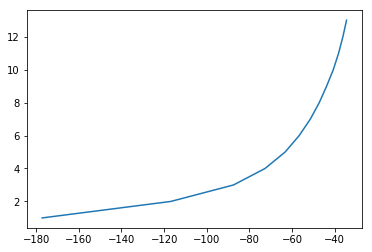

In [34]:
plt.plot(score, Ks)

In [8]:
kmn = KMeans(n_clusters=6)
kmn.fit(train_X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [9]:
kmn.predict(test_X[:2])

array([1, 3], dtype=int32)